# Quiz 2

BEFORE YOU START THIS QUIZ:

1. Click on "Copy to Drive" to make a copy of the quiz

2. Click on "Share",
    
3. Click on "Change" and select "Anyone with this link can edit"
    
4. Click "Copy link" and

5. Paste the link into [this Canvas assignment](https://canvas.olin.edu/courses/315/assignments/4928).

This quiz is based on Chapters 4 and 5 of [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2021 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from utils import decorate

## Question 1

Let's see if we can find a graph model that does a better job matching the clustering, path length, and degree distribution of online social networks.

Here's the Facebook data from Chapter 4 again.

In [3]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')

In [4]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [5]:
fb = read_graph('facebook_combined.txt.gz')

Here are the number of nodes, `n`, the number of edges, `m`, and the average degree, `k`.

In [6]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
n, m, k

(4039, 88234, 44)

The average clustering coefficient is about 0.6

In [7]:
from networkx.algorithms.approximation import average_clustering

In [8]:
C = average_clustering(fb)
C

0.618

The average path length is short.

In [9]:
def random_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = G.nodes()
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(random_path_lengths(G, nodes, trials))

In [10]:
L = estimate_path_length(fb)
L

3.706

And the standard deviation of degree is high.

In [11]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

In [12]:
np.mean(degrees(fb)), np.std(degrees(fb))

(43.69101262688784, 52.41411556737521)

## FOF model

I propose a new graph model called FOF for "friends of friends".

It starts with a complete graph with `k+1` nodes, so initially all nodes have degree `k`.  

Then we generate the remaining nodes like this:

0. Create a new node we'll call the source.

1.  Select a random target uniformly from existing nodes.

2.  Iterate through the friends of the target.  For each one, with probability `p`, form a triangle that includes the source, friend, and a random friend of the friend.

3.  Finally, connect the source and target.

Fill in the following function to implement this process.

Hints:

1. You can use `flip`, provided below.

2. To create the complete graph, I used `nx.complete_graph`. 

3. I found it helpful to write a separate function to generate triangles.

In [13]:
def fof_graph(n, k, p=0.25):
    """Make a FOF graph.
    
    n: number of nodes
    k: average degree
    p: probability of adding a triangle
    
    returns: nx.Graph
    """
    
    # FILL THIS IN

In [14]:
def flip(p):
    return np.random.random() < p

In [15]:
# Solution

def fof_graph(n, k, p=0.25):
    """Make a FOF graph.
    
    n: number of nodes
    k: average degree
    p: probability of adding a triangle
    
    returns: nx.Graph
    """
    # start with a completely connected core
    G = nx.complete_graph(k+1)

    for source in range(len(G), n):
        # choose a random node
        target = np.random.choice(list(G.nodes))
        
        # enumerate neighbors of target and add triangles
        friends = list(G.neighbors(target))
        for friend in friends:
            if flip(p):
                triangle(G, source, friend)

        # connect source and target
        G.add_edge(source, target)
            
    return G

In [16]:
# Solution

def triangle(G, source, friend):
    """Chooses a random neighbor of `friend` and makes a triangle.
    
    Triangle connects `source`, `friend`, and a random neighbor of `friend`.
    """
    fof = set(G[friend])
    if source in G:
        fof -= set(G[source])
    if fof:
        w = np.random.choice(list(fof))
        G.add_edge(source, w)
    G.add_edge(source, friend)

Use your function to make a FOF graph with the same number of nodes as the Facebook data, and approximately the same number of edges.
You might have to adjust `p` to get the number of edges right.

In [17]:
# Solution

fof = fof_graph(n, k, p=0.25)
len(fof), len(fof.edges())

(4039, 94028)

You can run the next few cells to see how well the result matches the Facebook data (but it's not necessary for the quiz).

Here's the average clustering.

In [18]:
C, average_clustering(fof)

(0.618, 0.22)

And the path length.

In [19]:
L, estimate_path_length(fof)

(3.706, 2.89)

And the degree distribution.

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [20]:
from empiricaldist import Cdf

cdf_fb = Cdf.from_seq(degrees(fb), name='Facebook')
cdf_fof = Cdf.from_seq(degrees(fof), name='FOF')

Here's the CDF on a log-x scale.

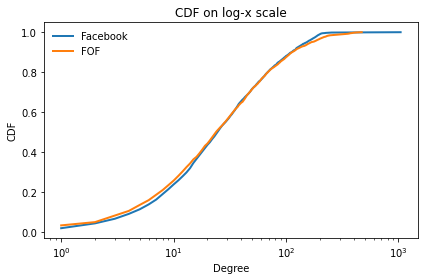

In [21]:
cdf_fb.plot()
cdf_fof.plot()

decorate(xlabel='Degree',
         ylabel='CDF',
         xscale='log',
         title='CDF on log-x scale')

And the complementary CDF on a log-log scale.

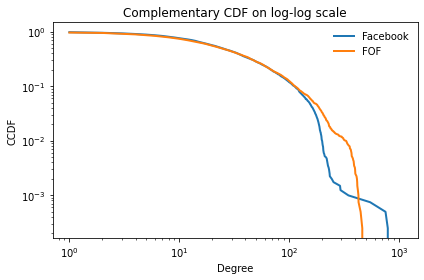

In [22]:
(1 - cdf_fb).plot()
(1 - cdf_fof).plot()

decorate(xlabel='Degree',
         ylabel='CCDF',
         xscale='log', 
         yscale='log',
         title='Complementary CDF on log-log scale')

## Question 2

Here's the code from Chapter 5 that makes a 1-D cellular automaton.

In [23]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1
        
    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.randint(2, size=self.m)
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Purples', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

In [24]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

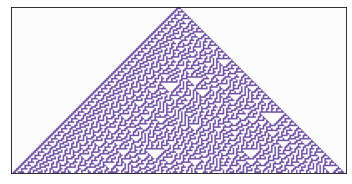

In [25]:
rule = 30
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)
ca.draw()

Make a class called `Cell1D5N` that implements a 1-D CA with a 5 cell neigborhood.
You can either modify the code above, or add new code below.

To make the table, you don't have to decode a rule number; instead, generate a random array of `1`s and `0`s like this:

```
np.random.choice([0, 1], size=size, p=[1-p, p])
```

The parameter `p` controls the proportion of `1`s. Your `__init__` method should take `p` as a parameter instead of `rule`.

In [26]:
# Solution

class Cell1D5N:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, p, n, m=None, seed=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        if seed:
            np.random.seed(seed)
        self.table = np.random.choice([0, 1], size=32, p=[1-p, p])
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.randint(2, size=self.m)
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [16, 8, 4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Purples', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

Use the following code to test your implementation.

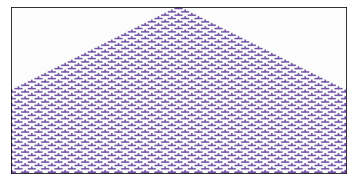

In [27]:
p = 0.5
n = 100
ca = Cell1D5N(p, n)
ca.start_single()
ca.loop(n-1)
ca.draw()